In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.family'] = 'Helvetica Light'
plt.rc('axes', unicode_minus=False)

import sys
sys.path.append('../d03_src/')
import vars
import process_graph
import process_complaints

# Processing 311 complaints into the New York City network

In this notebook we walk through the main functions used to:

- Create a network with NYC geometries (either census tracts or geohashes)
- Trim this network according to land area, park area, and population tresholds
- Aggregate flood 311 complaints into nodes of the network

## 1. Collecting the NYC network

The functions that collect and process the network can be found in `d03_src/process_graph.py`.

In [2]:
nyc_boroughs = gpd.read_file('../d01_data/d01_raw/d02_spatial-data/NYC-boroughs/NYC-boroughs.shp')
nyc_boundary = gpd.GeoDataFrame(geometry=[nyc_boroughs.unary_union], crs=nyc_boroughs.crs).to_crs(vars._projected_crs)

### 1a. Census network

We use census tracts for the results in the main paper. To collect census tracts, we make use of the library `pygris`. Our function `process_graph.generate_graph_census` collects the census graph. We have three data cleaning options:

- Whether to remove nodes with low population. Pass `remove_zeropop=True` and set `tresh_population` to the minimum population (we recommend setting this to True to avoid issues with logarithms).
- Whether to remove nodes with high percentage of park area. Pass `remove_parks=True` and set `tresh_parkarea` to the maximum park area allowed.
- Whether to remove nodes with high percentage of water area. Pass `remove_water=True`.

Further parameters are documented in the function.

In [3]:
gdf_census, graph_census = process_graph.generate_graph_census(remove_zeropop=True, tresh_population=100,
                                                               remove_parks=True, tresh_parkarea=3/4,
                                                               remove_water=True)

Using the default year of 2021
Using FIPS code '36' for input 'NY'
Using FIPS code '061' for input 'New York'
Using FIPS code '005' for input 'Bronx'
Using FIPS code '047' for input 'Kings'
Using FIPS code '081' for input 'Queens'
Using FIPS code '085' for input 'Richmond'


/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 5 islands with ids: 70, 150, 869, 1120, 1530.
  warnings.warn(message)


As you can see from the warning, NYC does not create a connected network at first. We by default enforce connection by adding one edge between the closest pair of nodes on separate components. You can pass `enforce_connection=False` to the `generate_graph_census` function if you do not mind a disconnected graph. The graph looks like this:

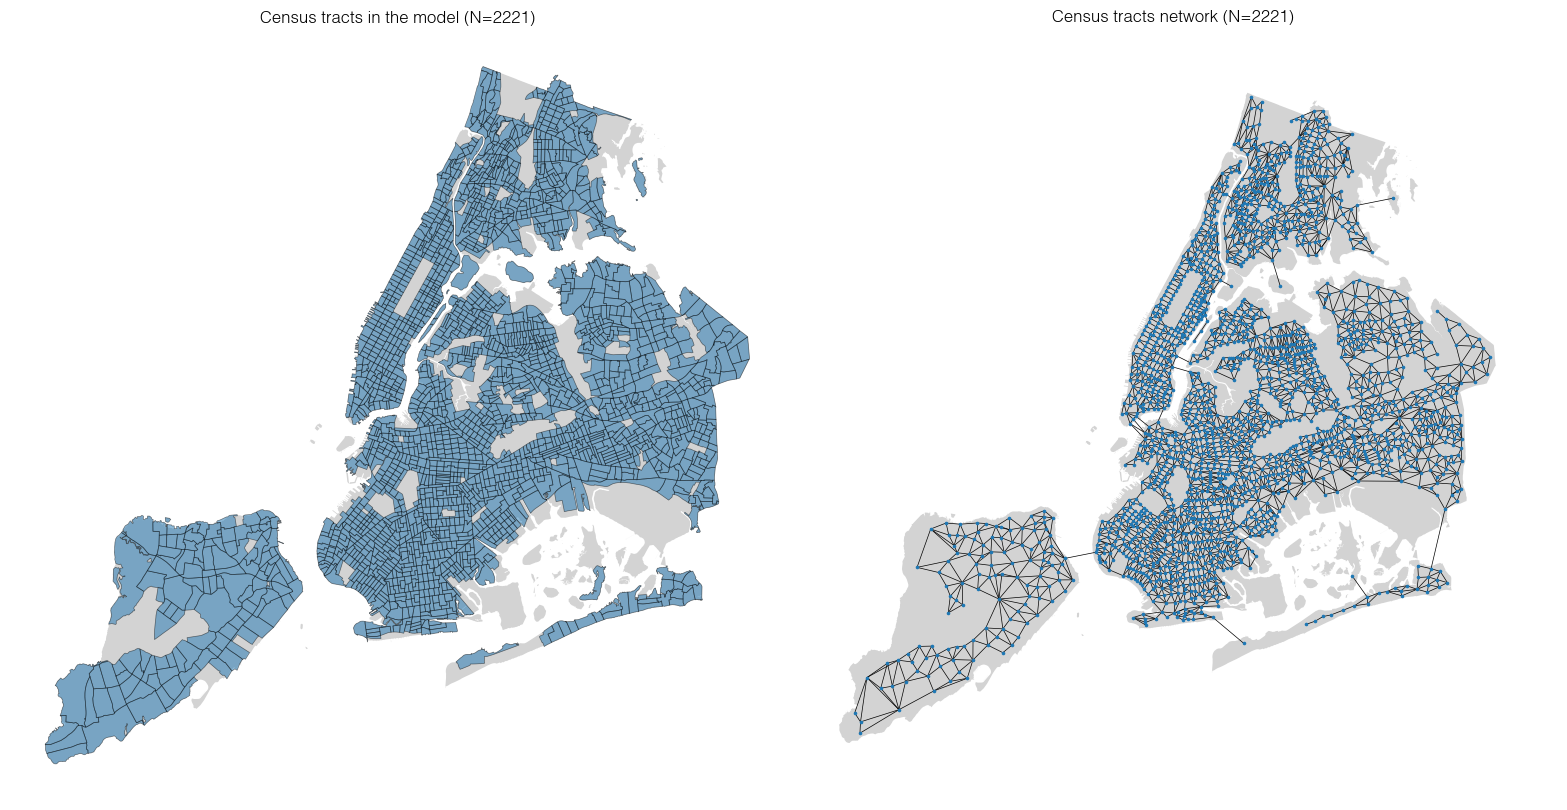

In [4]:
fig, Axes = plt.subplots(figsize=(20,10), ncols=2)

#In both plots we need a base gdf:
for ax in Axes:
    _ = nyc_boundary.plot(ax=ax, color='lightgrey')
    _ = ax.axis('off')

#In the first plot, show the census gdf:
_ = gdf_census.plot(ax=Axes[0], alpha=0.5, linewidth=0.5, edgecolor='k')
_ = Axes[0].set_title(f'Census tracts in the model (N={len(gdf_census)})')

#In the second plot, show the network:
centroids_census = gdf_census.centroid
positions_census = {n:(centroid.x, centroid.y) for n, centroid in enumerate(centroids_census)}
_ = nx.draw(graph_census, pos=positions_census, ax=Axes[1], node_size=2.5, width=0.5)
_ = Axes[1].set_title(f'Census tracts network (N={len(gdf_census)})')

plt.subplots_adjust(wspace=0)
plt.show()

### 1b. Geohash network

The function `process_graph.generate_graph_geohash` works very similarly to the census function described above. Two remarks:

- For water removal, we opt for completely removing geohashes with a high percentage of water area (so that we do not end up with geohashes that are extremely small in area). Pass `tresh_water` to indicate the maximum fraction of water area allowed in a geohash.
- Geohashes are determined by a precision. Pass either 5, 6 or 7 to `precision` to refine or aggregate the network (we use 6).
- To understand how we determine the population by geohash, see the notebook on demographic processing.

Further parameters are documented in the function.

In [5]:
gdf_hash, graph_hash = process_graph.generate_graph_geohash(precision=6,
                                                            remove_zeropop=True, tresh_population=100,
                                                            remove_parks=True, tresh_parkarea=3/4,
                                                            remove_water=True, tresh_water=1/3)

/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  warnings.warn(message)


As you can see from the warning, NYC does not create a connected network at first. We by default enforce connection by adding one edge between the closest pair of nodes on separate components. You can pass `enforce_connection=False` to the `generate_graph_geohash` function if you do not mind a disconnected graph. The graph looks like this:

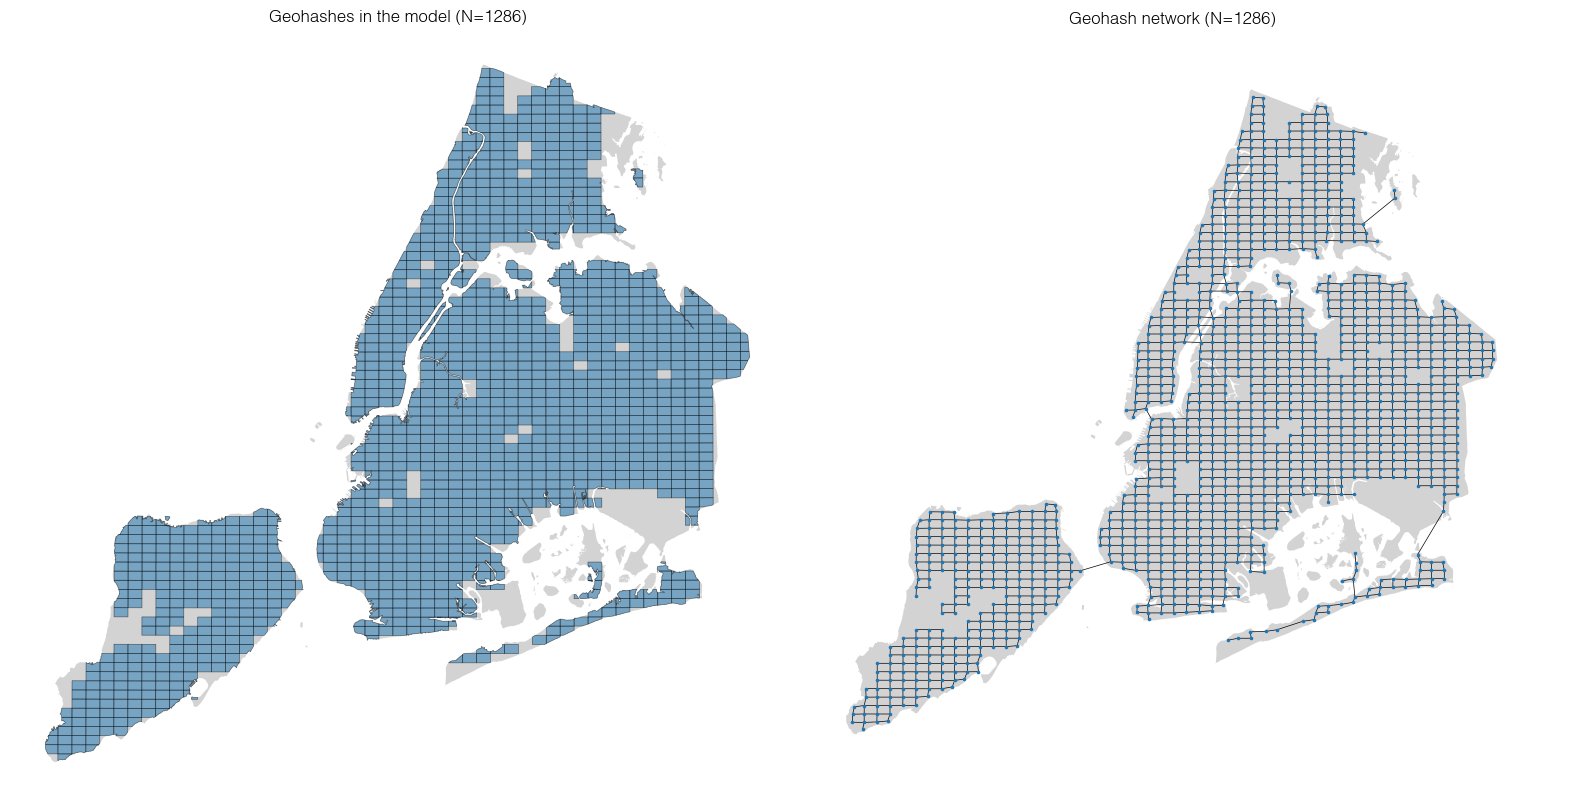

In [6]:
fig, Axes = plt.subplots(figsize=(20,10), ncols=2)

#In both plots we need a base gdf:
for ax in Axes:
    _ = nyc_boundary.plot(ax=ax, color='lightgrey')
    _ = ax.axis('off')

#In the first plot, show the geohash gdf:
_ = gdf_hash.plot(ax=Axes[0], alpha=0.5, linewidth=0.5, edgecolor='k')
_ = Axes[0].set_title(f'Geohashes in the model (N={len(gdf_hash)})')

#In the second plot, show the network:
centroids_hash = gdf_hash.centroid
positions_hash = {n:(centroid.x, centroid.y) for n, centroid in enumerate(centroids_hash)}
_ = nx.draw(graph_hash, pos=positions_hash, ax=Axes[1], node_size=2.5, width=0.5)
_ = Axes[1].set_title(f'Geohash network (N={len(gdf_hash)})')

plt.subplots_adjust(wspace=0)
plt.show()

## 2. Collecting 311 flood complaints

The 311 data is downloaded from https://data.cityofnewyork.us/Social-Services/Street-Flooding/wymi-u6i8 . We did not upload it due to size and as it is publicly available. If you include it in the directory `d01_data/d01_raw/d01_311-data/` with the name `street-flooding_raw.csv`, this notebook should run normally.

### 2a. Basic EDA

In [7]:
complaints_raw_df = pd.read_csv(vars._path_311_floods, low_memory=False)

In [8]:
display(complaints_raw_df.head())

Unique Key            Created Date             Closed Date Agency  \
0    41871468  03/04/2019 04:42:00 AM  03/05/2019 09:50:00 AM    DEP   
1    41871485  03/04/2019 11:12:00 AM  03/04/2019 01:45:00 PM    DEP   
2    41871510  03/04/2019 03:32:00 PM  03/07/2019 09:50:00 AM    DEP   
3    41872602  03/04/2019 02:34:00 PM  03/07/2019 10:55:00 AM    DEP   
4    41872614  03/04/2019 09:10:00 AM  03/04/2019 02:30:00 PM    DEP   

                              Agency Name Complaint Type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             Descriptor  Location Type  Incident Zip      Incident Address  \
0  Street Flooding (SJ)            NaN       11219.0        1169 54 STREET   
1  Street Flooding (SJ)            NaN       11358.0      43-47 167 STREET   
2  Street Flooding (SJ)            NaN       10314.0                   NaN   
3  Street Flooding (SJ)            NaN       10306.0          143 BADEN PL   
4  Street Flooding (SJ)            NaN       11222.0  700 MANHATTAN AVENUE   

   ... Vehicle Type Taxi Company Borough Taxi Pick Up Location  \
0  ...          NaN                  NaN                   NaN   
1  ...          NaN                  NaN                   NaN   
2  ...          NaN                  NaN                   NaN   
3  ...          NaN                  NaN                   NaN   
4  ...          NaN                  NaN                   NaN   

  Bridge Highway Name Bridge Highway Direction Road Ramp  \
0                 NaN                      NaN       NaN   
1                 NaN                      NaN       NaN   
2                 NaN                      NaN       NaN   
3                 NaN                      NaN       NaN   
4                 NaN                      NaN       NaN   

  Bridge Highway Segment   Latitude  Longitude  \
0                    NaN  40.634048 -73.998026   
1                    NaN  40.757959 -73.799585   
2                    NaN  40.596065 -74.141859   
3                    NaN  40.572992 -74.090677   
4                    NaN  40.725688 -73.951871   

                                   Location  
0    (40.63404758241534, -73.9980256174884)  
1    (40.75795869781174, -73.7995845550709)  
2   (40.59606542635006, -74.14185869005213)  
3   (40.57299224518873, -74.09067740183956)  
4  (40.725688254398065, -73.95187138290582)  

[5 rows x 41 columns]

In [9]:
display(complaints_raw_df.iloc[0])

Unique Key                                                                 41871468
Created Date                                                 03/04/2019 04:42:00 AM
Closed Date                                                  03/05/2019 09:50:00 AM
Agency                                                                          DEP
Agency Name                                  Department of Environmental Protection
Complaint Type                                                                Sewer
Descriptor                                                     Street Flooding (SJ)
Location Type                                                                   NaN
Incident Zip                                                                11219.0
Incident Address                                                     1169 54 STREET
Street Name                                                               54 STREET
Cross Street 1                                                              

We can take a look at the time of these complaints using the created date column. The number of complaints seem to be very seasonal.

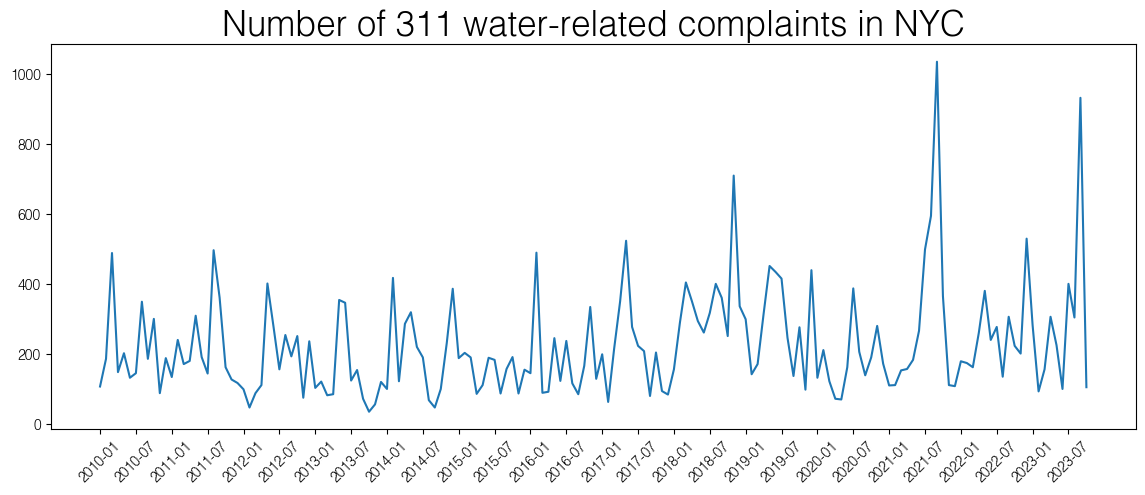

In [10]:
complaints_YYYYMM = complaints_raw_df['Created Date'].apply(lambda s: s[6:10] + '-' + s[:2]).sort_values()
complaints_months = complaints_YYYYMM.value_counts(sort=False).index.values
complaints_no = complaints_YYYYMM.value_counts(sort=False).values

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(complaints_no)
ax.set_xticks(range(0, len(complaints_months), 6))
ax.set_xticklabels(complaints_months[::6], rotation=45)
ax.set_title('Number of 311 water-related complaints in NYC', size=25)

plt.show()

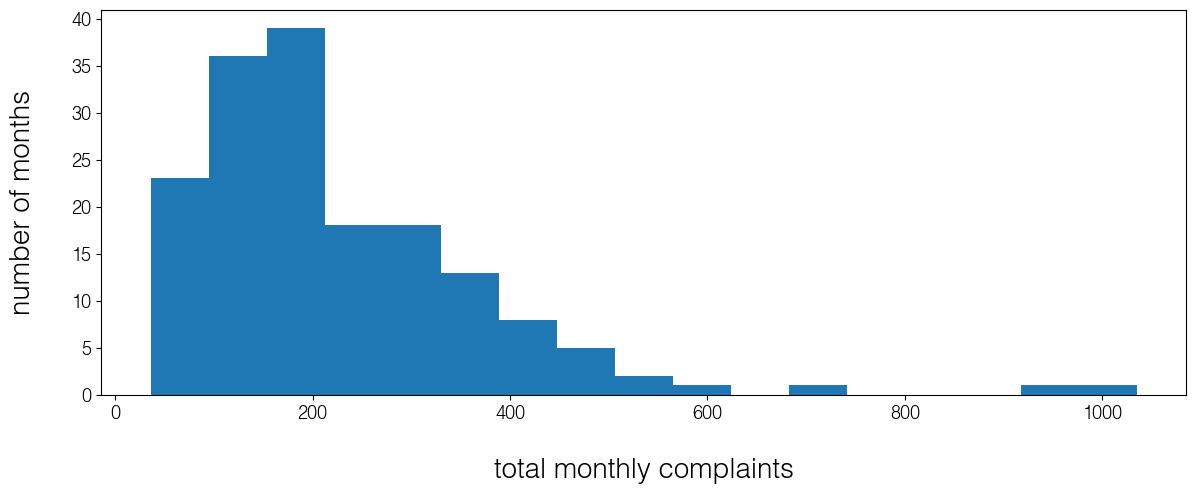

In [11]:
fig, ax = plt.subplots(figsize=(14,5))
hist = plt.hist(complaints_no, bins='auto')
ax.set_xlabel('\ntotal monthly complaints', fontsize=20)
ax.set_ylabel('number of months\n', fontsize=20)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)

### 2b. Linking complaints to the network

To link the complaints to the network we use the functions from `process_complaints`. The function `get_complaints` filters complaints from a certain start date---check the `vars` file for the dates of each storm! The full signature is:

In [12]:
process_complaints.get_complaints?

Signature:
process_complaints.get_complaints(
    aggregation_gdf,
    event_date,
    filter_mode='duration',
    event_duration=7,
    train_duration=2,
    train_percentage=0.1,
    end_date=None,
    train_end_date=None,
    return_test_complaints=False,
    binary=True,
    return_filtered_gdf=False,
    path_311='/share/garg/gs665/networks_underreporting_public/d01_data/d01_raw/d01_311-data/street-flooding-2023_raw.csv',
    projected_crs='EPSG:2263',
)
Docstring:
Collects 311 complaints relative to a certain event per
    geographic unit.

Filter events according to dates following two possible
    modes: fixed duration or fixed end.

Parameters
----------
aggregation_gdf : Geopandas.GeoDataFrame
    geodataframe with units we aggregate complaints

event_date : datetime.datetime
    date the event happens, will filter complaints at strictly
    larger dates

filter_mode : str, `duration` or `end` or `percentage`
    how to filter the complaints temporally

event_duration : int
 

In the paper, we use 7 days of reports for the testing set and cut the training set when 8% of the nodes have a report. The flood start dates are documented in the variables file `d03_src/vars.py`

In [13]:
T_train_census, T_test_census = {}, {}
T_train_hash,   T_test_hash   = {}, {}

for storm in ['henri', 'ida', 'ophelia']:
    print(f'\nStorm: {storm.capitalize()}')
    print('Census:')
    T_train_census[storm], T_test_census[storm] = process_complaints.get_complaints(gdf_census.copy(),
                                                                                    event_date=vars._floods_start_date[storm],
                                                                                    filter_mode='percentage',
                                                                                    event_duration=7,
                                                                                    train_percentage=0.08,
                                                                                    return_test_complaints=True)
    print(f'There are {sum(T_train_census[storm])} training reports and {sum(T_test_census[storm])} testing reports ({sum(T_test_census[storm][T_train_census[storm] != 1])} new)')
    print('Geohash:')
    T_train_hash[storm], T_test_hash[storm]     = process_complaints.get_complaints(gdf_hash.copy(),
                                                                                    event_date=vars._floods_start_date[storm],
                                                                                    filter_mode='percentage',
                                                                                    event_duration=7,
                                                                                    train_percentage=0.08,
                                                                                    return_test_complaints=True)
    print(f'There are {sum(T_train_hash[storm])} training reports and {sum(T_test_hash[storm])} testing reports ({sum(T_test_hash[storm][T_train_hash[storm] != 1])} new)')
    


Storm: Henri
Census:
Train end date is: 2021-08-23 17:52:00 (1 day, 21:52:00 hours after the start)
There are 176.0 training reports and 58.0 testing reports (38.0 new)
Geohash:
Train end date is: 2021-08-22 15:44:00 (19:44:00 hours after the start)
There are 102.0 training reports and 129.0 testing reports (101.0 new)

Storm: Ida
Census:
Train end date is: 2021-09-01 23:14:00 (4:14:00 hours after the start)
There are 177.0 training reports and 346.0 testing reports (264.0 new)
Geohash:
Train end date is: 2021-09-01 22:23:00 (3:23:00 hours after the start)
There are 101.0 training reports and 369.0 testing reports (314.0 new)

Storm: Ophelia
Census:
Train end date is: 2023-09-29 10:02:00 (4:02:00 hours after the start)
There are 177.0 training reports and 283.0 testing reports (210.0 new)
Geohash:
Train end date is: 2023-09-29 09:14:00 (3:14:00 hours after the start)
There are 107.0 training reports and 294.0 testing reports (235.0 new)


We can visualize the data as follows:

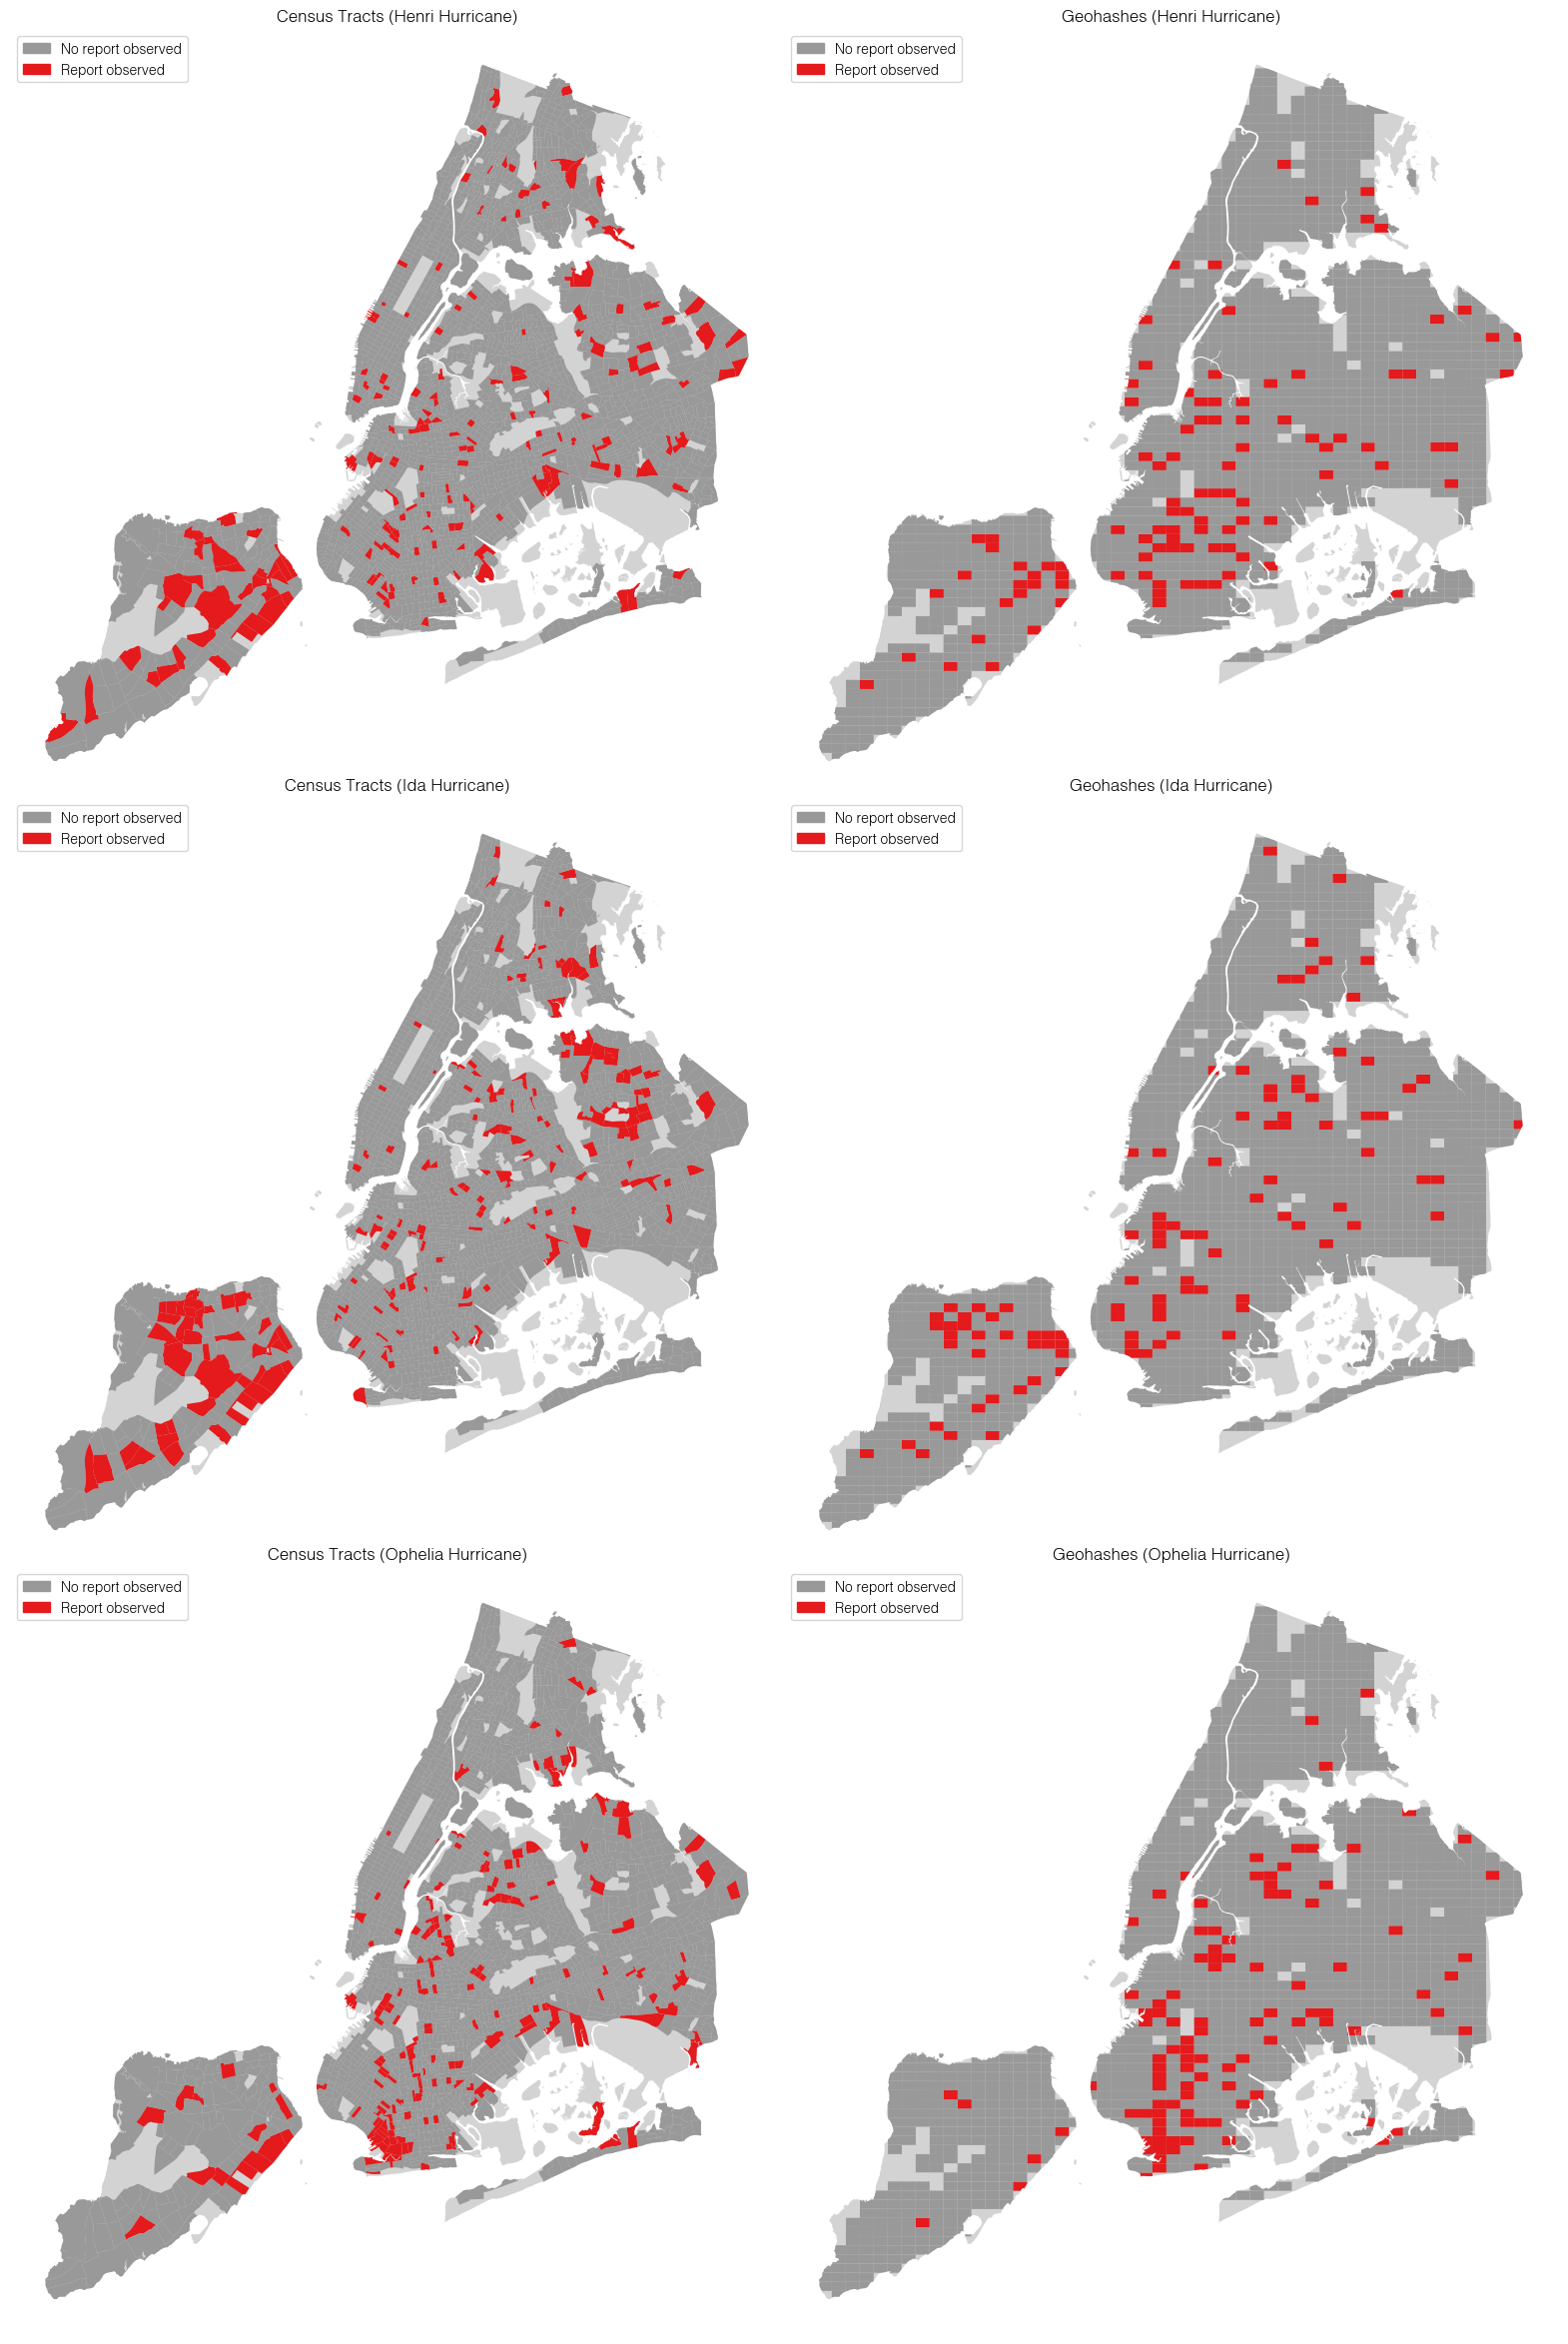

In [14]:
fig, Axes = plt.subplots(figsize=(20,30), ncols=2, nrows=3)

#In all plots we need a base gdf:
for ax in Axes.flatten():
    _ = nyc_boundary.plot(ax=ax, color='lightgrey')
    _ = ax.axis('off')
    #LEGEND:
    set_cmap = mpl.colormaps['Set1']
    no_report = mpl.patches.Patch(color=set_cmap(0.9), label='No report observed')
    report = mpl.patches.Patch(color=set_cmap(0), label='Report observed')
    _ = ax.legend(handles=[no_report, report], loc='upper left')

for row, storm in enumerate(['henri', 'ida', 'ophelia']):
    
    _ = gdf_census.plot(T_train_census[storm], ax=Axes[row, 0], linewidth=0, cmap='Set1_r')
    _ = Axes[row,0].set_title(f'Census Tracts ({storm.capitalize()} Hurricane)')
    
    _ = gdf_hash.plot(T_train_hash[storm], ax=Axes[row, 1], linewidth=0, cmap='Set1_r')
    _ = Axes[row,1].set_title(f'Geohashes ({storm.capitalize()} Hurricane)')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

We can also verify that binarizing the reports does not make that much of a difference by collecting the raw count of reports. We set `binary=False` in the `get_complaints` function:

In [15]:
T_train_census_nb = {}
T_train_hash_nb = {}

for storm in ['henri', 'ida', 'ophelia']:
    print(f'\nStorm: {storm.capitalize()}')
    print('Census:')
    T_train_census_nb[storm] = process_complaints.get_complaints(gdf_census.copy(),
                                                                 event_date=vars._floods_start_date[storm],
                                                                 filter_mode='percentage',
                                                                 event_duration=7,
                                                                 train_percentage=0.08,
                                                                 return_test_complaints=False,
                                                                 binary=False)
    display(100*round(pd.Series(T_train_census_nb[storm]).value_counts(normalize=True),4).sort_index())
    print('Geohash:')
    T_train_hash_nb[storm] = process_complaints.get_complaints(gdf_hash.copy(),
                                                               event_date=vars._floods_start_date[storm],
                                                               filter_mode='percentage',
                                                               event_duration=7,
                                                               train_percentage=0.08,
                                                               return_test_complaints=False,
                                                               binary=False)
    display(100*round(pd.Series(T_train_hash_nb[storm]).value_counts(normalize=True),4).sort_index())


Storm: Henri
Census:
Train end date is: 2021-08-23 17:52:00 (1 day, 21:52:00 hours after the start)


0.0     92.08
1.0      5.90
2.0      0.86
3.0      0.68
4.0      0.05
5.0      0.18
6.0      0.18
10.0     0.05
11.0     0.05
Name: proportion, dtype: float64

Geohash:
Train end date is: 2021-08-22 15:44:00 (19:44:00 hours after the start)


0.0     92.07
1.0      5.29
2.0      1.01
3.0      0.93
4.0      0.23
5.0      0.08
6.0      0.16
7.0      0.08
11.0     0.08
13.0     0.08
Name: proportion, dtype: float64


Storm: Ida
Census:
Train end date is: 2021-09-01 23:14:00 (4:14:00 hours after the start)


0.0     92.03
1.0      5.81
2.0      1.22
3.0      0.36
4.0      0.23
5.0      0.18
6.0      0.05
8.0      0.09
16.0     0.05
Name: proportion, dtype: float64

Geohash:
Train end date is: 2021-09-01 22:23:00 (3:23:00 hours after the start)


0.0     92.15
1.0      6.07
2.0      1.32
3.0      0.23
4.0      0.08
8.0      0.08
24.0     0.08
Name: proportion, dtype: float64


Storm: Ophelia
Census:
Train end date is: 2023-09-29 10:02:00 (4:02:00 hours after the start)


0.0    92.03
1.0     6.17
2.0     1.13
3.0     0.41
4.0     0.23
5.0     0.05
Name: proportion, dtype: float64

Geohash:
Train end date is: 2023-09-29 09:14:00 (3:14:00 hours after the start)


0.0    91.68
1.0     6.45
2.0     1.01
3.0     0.47
4.0     0.23
5.0     0.16
Name: proportion, dtype: float64

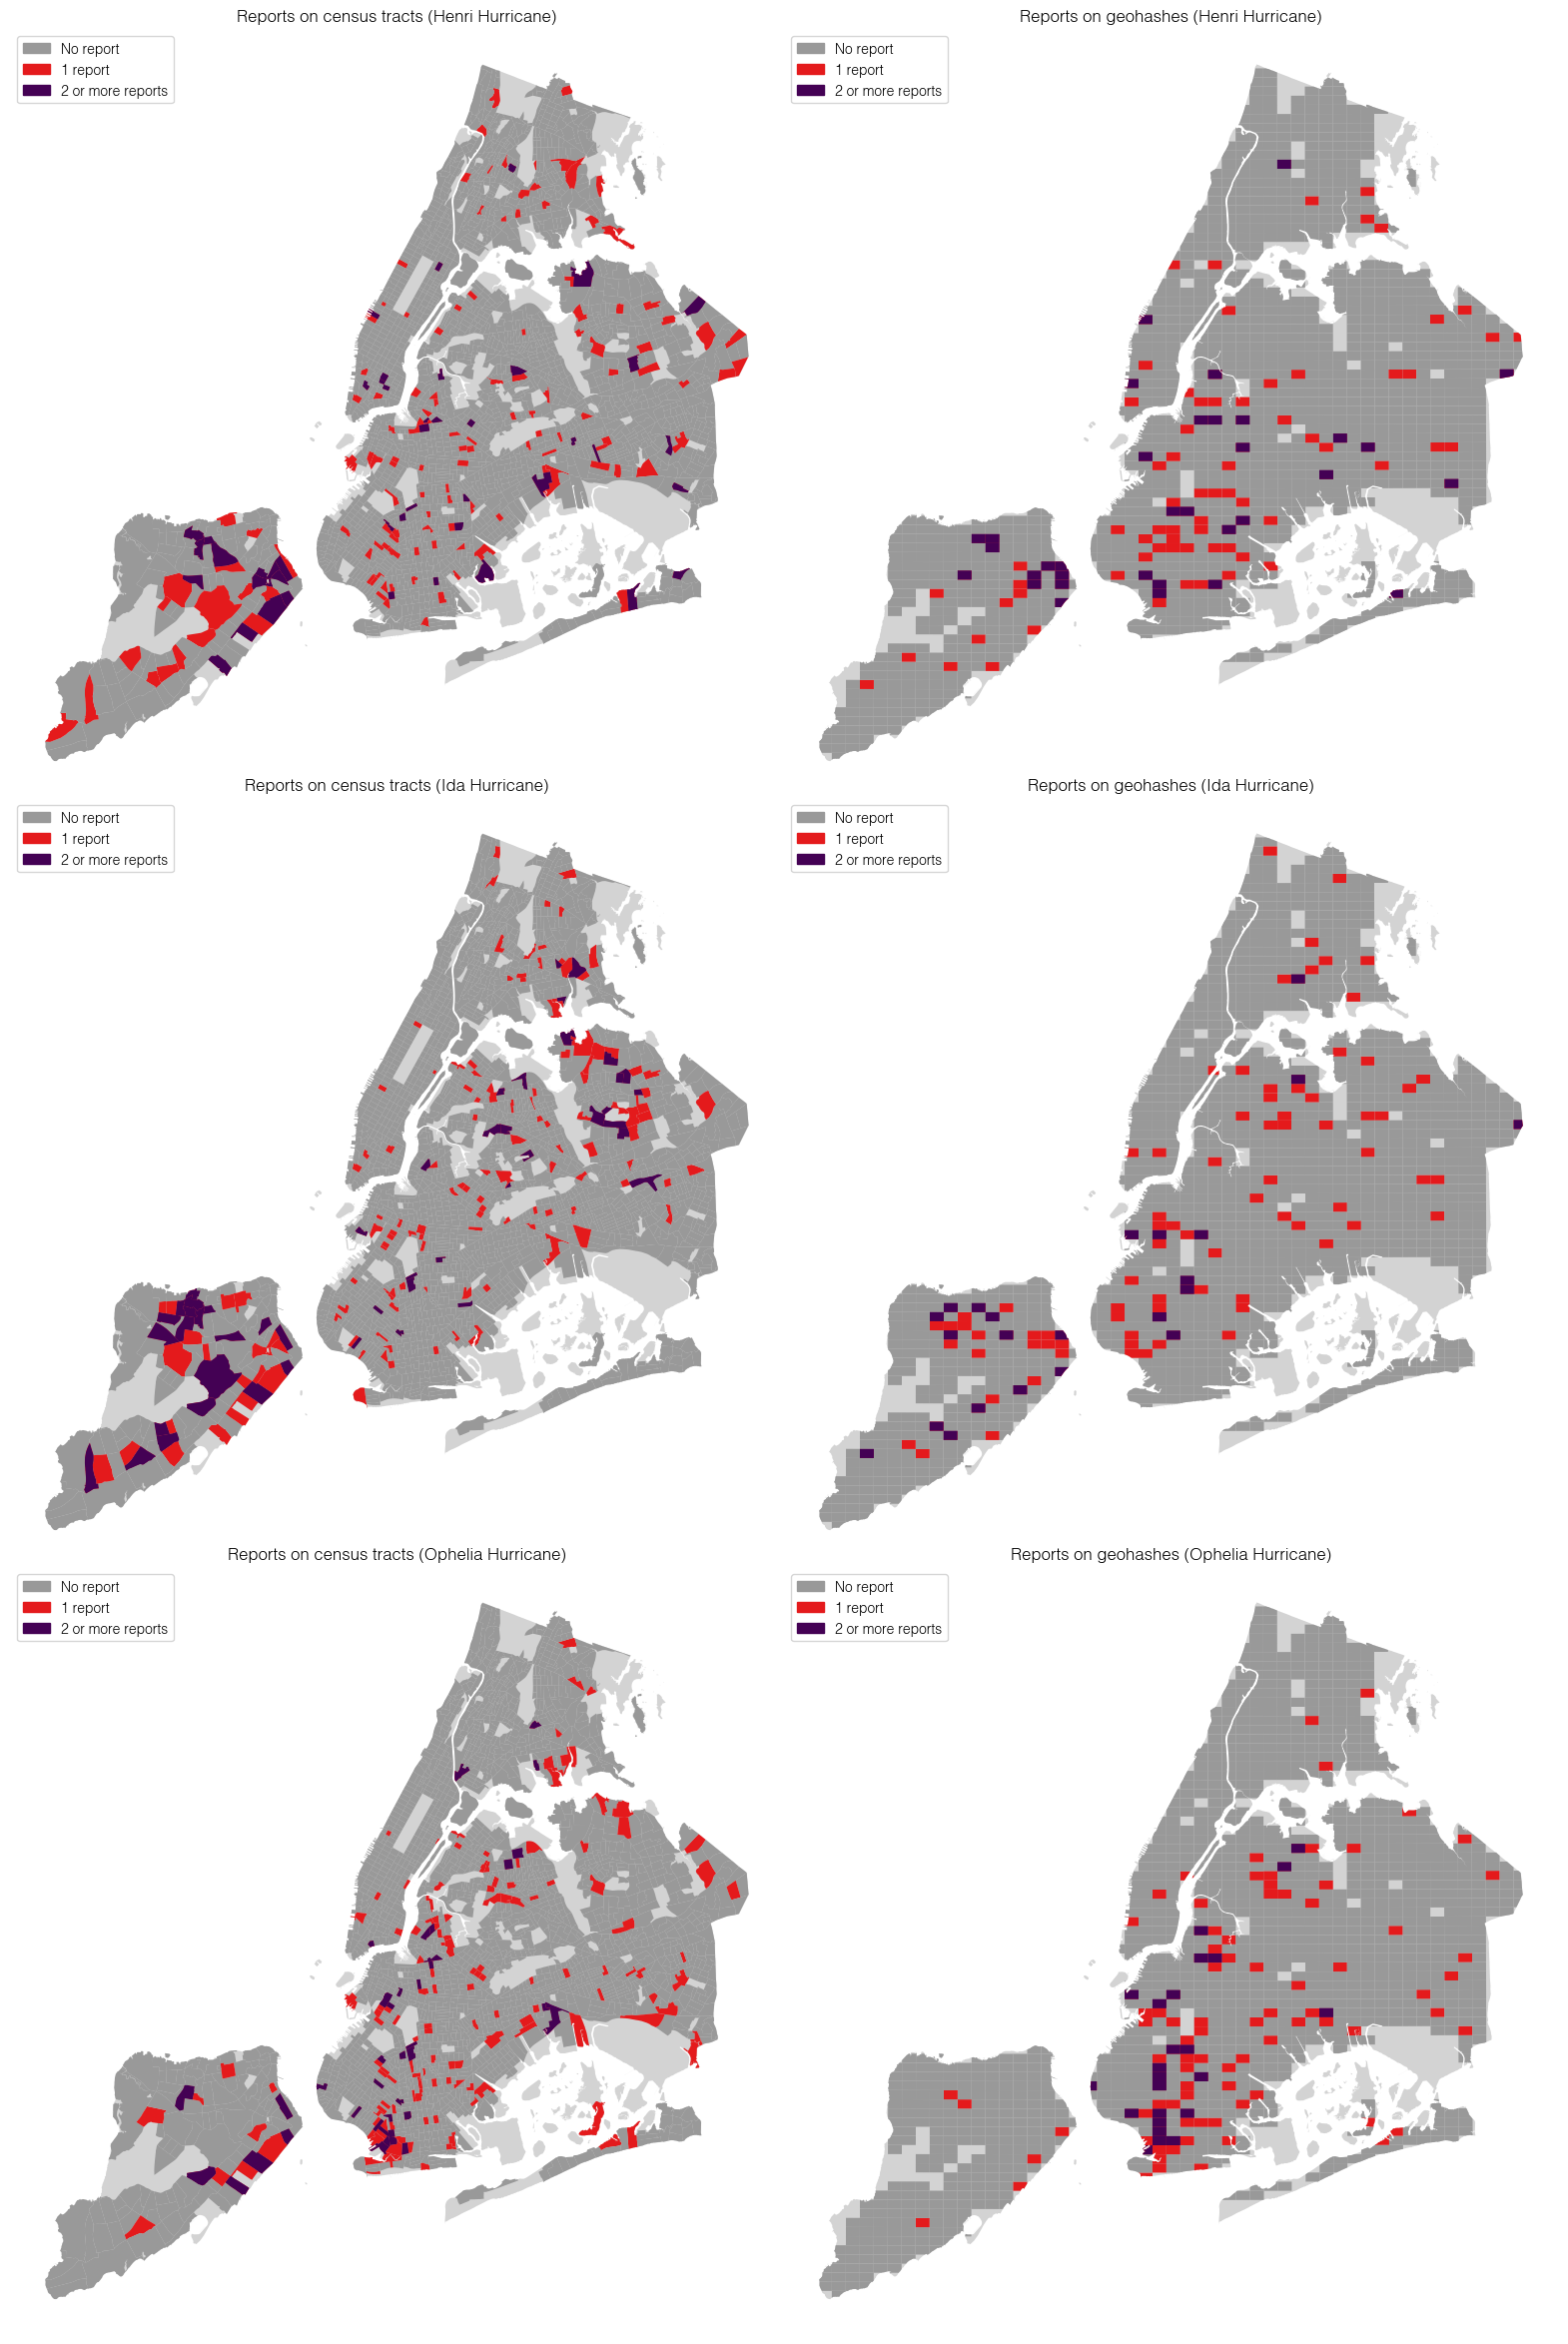

In [16]:
fig, Axes = plt.subplots(figsize=(20,30), ncols=2, nrows=3)

#In all plots we need a base gdf and a legend:
for ax in Axes.flatten():
    _ = nyc_boundary.plot(ax=ax, color='lightgrey')
    _ = ax.axis('off')
    #LEGEND:
    set_cmap = mpl.colormaps['Set1']
    vir_cmap = mpl.colormaps['viridis']
    no_report = mpl.patches.Patch(color=set_cmap(0.9), label='No report')
    report = mpl.patches.Patch(color=set_cmap(0), label='1 report')
    more_report = mpl.patches.Patch(color=vir_cmap(0), label='2 or more reports')
    _ = ax.legend(handles=[no_report, report, more_report], loc='upper left')
    


for row, storm in enumerate(['henri', 'ida', 'ophelia']):
    
    _ = gdf_census.plot(T_train_census[storm], ax=Axes[row, 0], linewidth=0, cmap='Set1_r')
    clipped_complaints = np.clip(T_train_census_nb[storm], a_min=0, a_max=2)
    clipped_complaints[clipped_complaints < 2] = np.nan
    _ = gdf_census.plot(clipped_complaints, ax=Axes[row, 0], linewidth=0)
    _ = Axes[row,0].set_title(f'Reports on census tracts ({storm.capitalize()} Hurricane)')
    
    _ = gdf_hash.plot(T_train_hash[storm], ax=Axes[row, 1], linewidth=0, cmap='Set1_r')
    clipped_complaints = np.clip(T_train_hash_nb[storm], a_min=0, a_max=2)
    clipped_complaints[clipped_complaints < 2] = np.nan
    _ = gdf_hash.plot(clipped_complaints, ax=Axes[row, 1], linewidth=0)
    _ = Axes[row,1].set_title(f'Reports on geohashes ({storm.capitalize()} Hurricane)')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

The paper brings the following map:

There are 48 tracts with multiple complaints, which is 27.1% of the tracts with a complaint
There are 23 geohashes with multiple complaints, which is 22.8% of the geohashes with a complaint


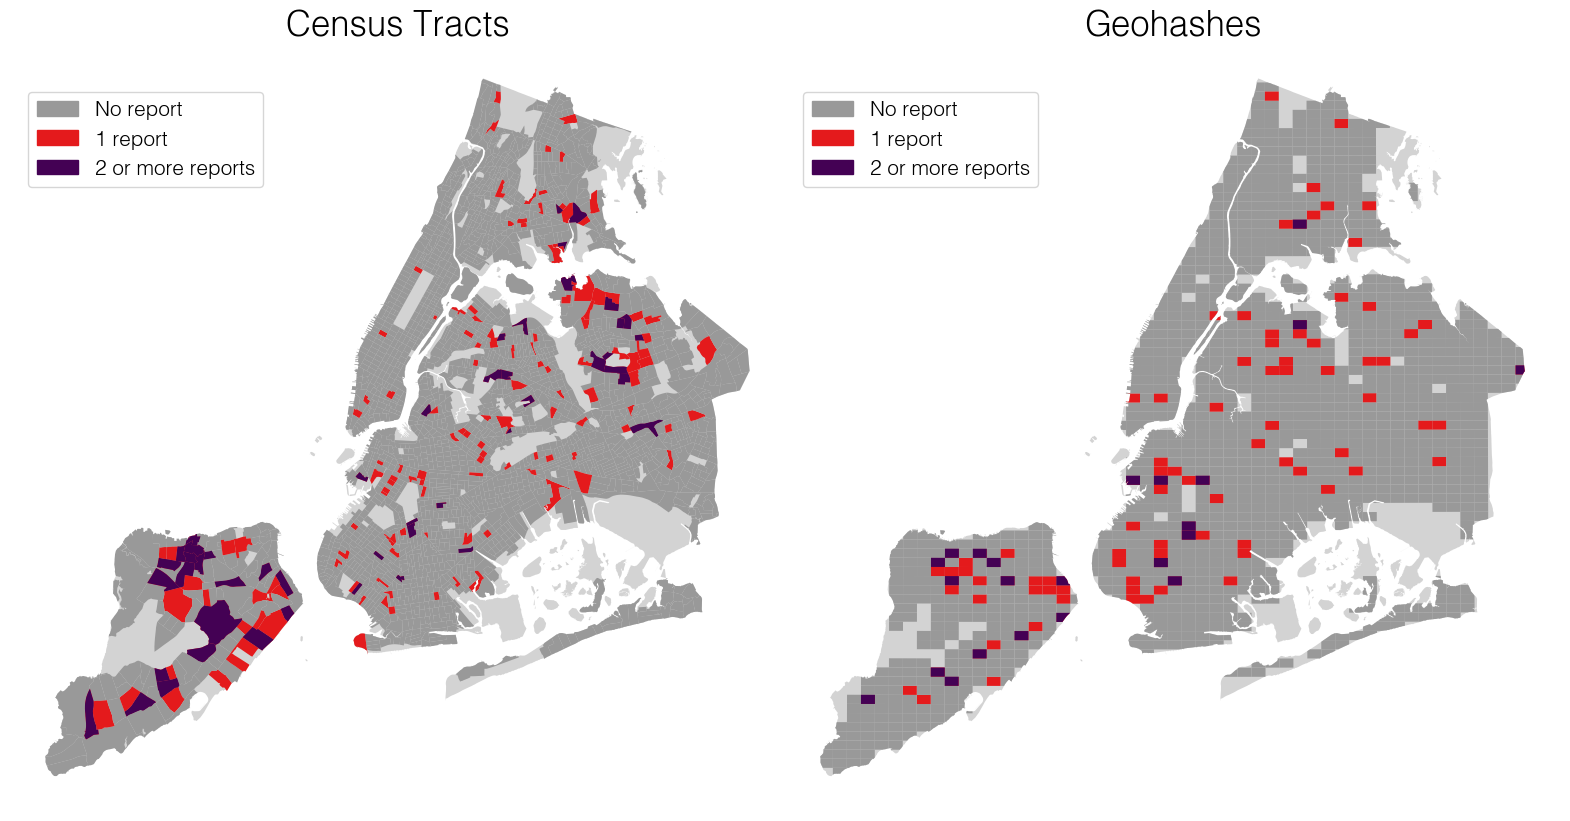

In [17]:
fig, Axes = plt.subplots(figsize=(20,10), ncols=2)

#In all plots we need a base gdf and a legend:
for ax in Axes.flatten():
    _ = nyc_boundary.plot(ax=ax, color='lightgrey')
    _ = ax.axis('off')
    #LEGEND:
    set_cmap = mpl.colormaps['Set1']
    vir_cmap = mpl.colormaps['viridis']
    no_report = mpl.patches.Patch(color=set_cmap(0.9), label='No report')
    report = mpl.patches.Patch(color=set_cmap(0), label='1 report')
    more_report = mpl.patches.Patch(color=vir_cmap(0), label='2 or more reports')
    _ = ax.legend(handles=[no_report, report, more_report], loc='upper left', bbox_to_anchor=(0.01, 0.95), fontsize=15)
    
storm='ida'

_ = gdf_census.plot(T_train_census[storm], ax=Axes[0], linewidth=0, cmap='Set1_r')
clipped_complaints = np.clip(T_train_census_nb[storm], a_min=0, a_max=2)
clipped_complaints[clipped_complaints < 2] = np.nan
_ = gdf_census.plot(clipped_complaints, ax=Axes[0], linewidth=0)
_ = Axes[0].set_title(f'Census Tracts', fontsize=25)
multiple = np.count_nonzero(~np.isnan(clipped_complaints))
atleastone = np.count_nonzero(T_train_census[storm])
print(f'There are {multiple} tracts with multiple complaints, which is {multiple/atleastone:.1%} of the tracts with a complaint')

_ = gdf_hash.plot(T_train_hash[storm], ax=Axes[1], linewidth=0, cmap='Set1_r')
clipped_complaints = np.clip(T_train_hash_nb[storm], a_min=0, a_max=2)
clipped_complaints[clipped_complaints < 2] = np.nan
_ = gdf_hash.plot(clipped_complaints, ax=Axes[1], linewidth=0)
_ = Axes[1].set_title(f'Geohashes', fontsize=25)
multiple = np.count_nonzero(~np.isnan(clipped_complaints))
atleastone = np.count_nonzero(T_train_hash[storm])
print(f'There are {multiple} geohashes with multiple complaints, which is {multiple/atleastone:.1%} of the geohashes with a complaint')

plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig('../d07_plots/SI_reports_training_ida.pdf', pad_inches=0.05, bbox_inches='tight', format='pdf')
plt.show()